## Istotność zmiennych dla klasyfikacji

In [9]:
# Import Required Libraries
import pandas as pd
from joblib import Parallel, delayed, load
import shap
import matplotlib.pyplot as plt

# Ensure the SHAP plots are displayed in the notebook
shap.initjs()

In [2]:
# Load Trained Classifiers
with open('../models/trained_classifiers.pkl', 'rb') as file:
    classifiers = load(file)

In [13]:
with open("../data/processed/modelling_data.pkl", "rb") as file:
    data = load(file)

X = data["X_test"]
y = data["y_test"]

In [4]:
# Summarize the background data
background = shap.sample(X, 100)
X_sample = shap.sample(X, 100)

In [5]:
# Initialize a dictionary to store SHAP explainers for each classifier
shap_explainers = {}

# Loop through each classifier and initialize the SHAP explainer
for clf_name, clf in classifiers.items():
    # Use TreeExplainer for tree-based models, otherwise use KernelExplainer
    if hasattr(clf, 'tree_'):
        explainer = shap.TreeExplainer(clf)
    else:
        explainer = shap.KernelExplainer(clf.predict, background)
    
    shap_explainers[clf_name] = explainer

# Compute SHAP values for the sampled data
#shap_values_dict = {clf_name: explainer.shap_values(X_sample) for clf_name, explainer in shap_explainers.items()}

# Display the computed SHAP values
#shap_values_dict

In [6]:
# Function to compute SHAP values and print the output
def compute_shap_values(clf_name, explainer, X_sample):
    shap_values = explainer.shap_values(X_sample)
    print(f"SHAP values for {clf_name}: {shap_values}")
    return clf_name, shap_values

# Parallel computation of SHAP values
shap_values_list = Parallel(n_jobs=-1)(
    delayed(compute_shap_values)(clf_name, explainer, X_sample) for clf_name, explainer in shap_explainers.items()
)

In [7]:
# Convert the list of tuples back to a dictionary
shap_values_dict = dict(shap_values_list)

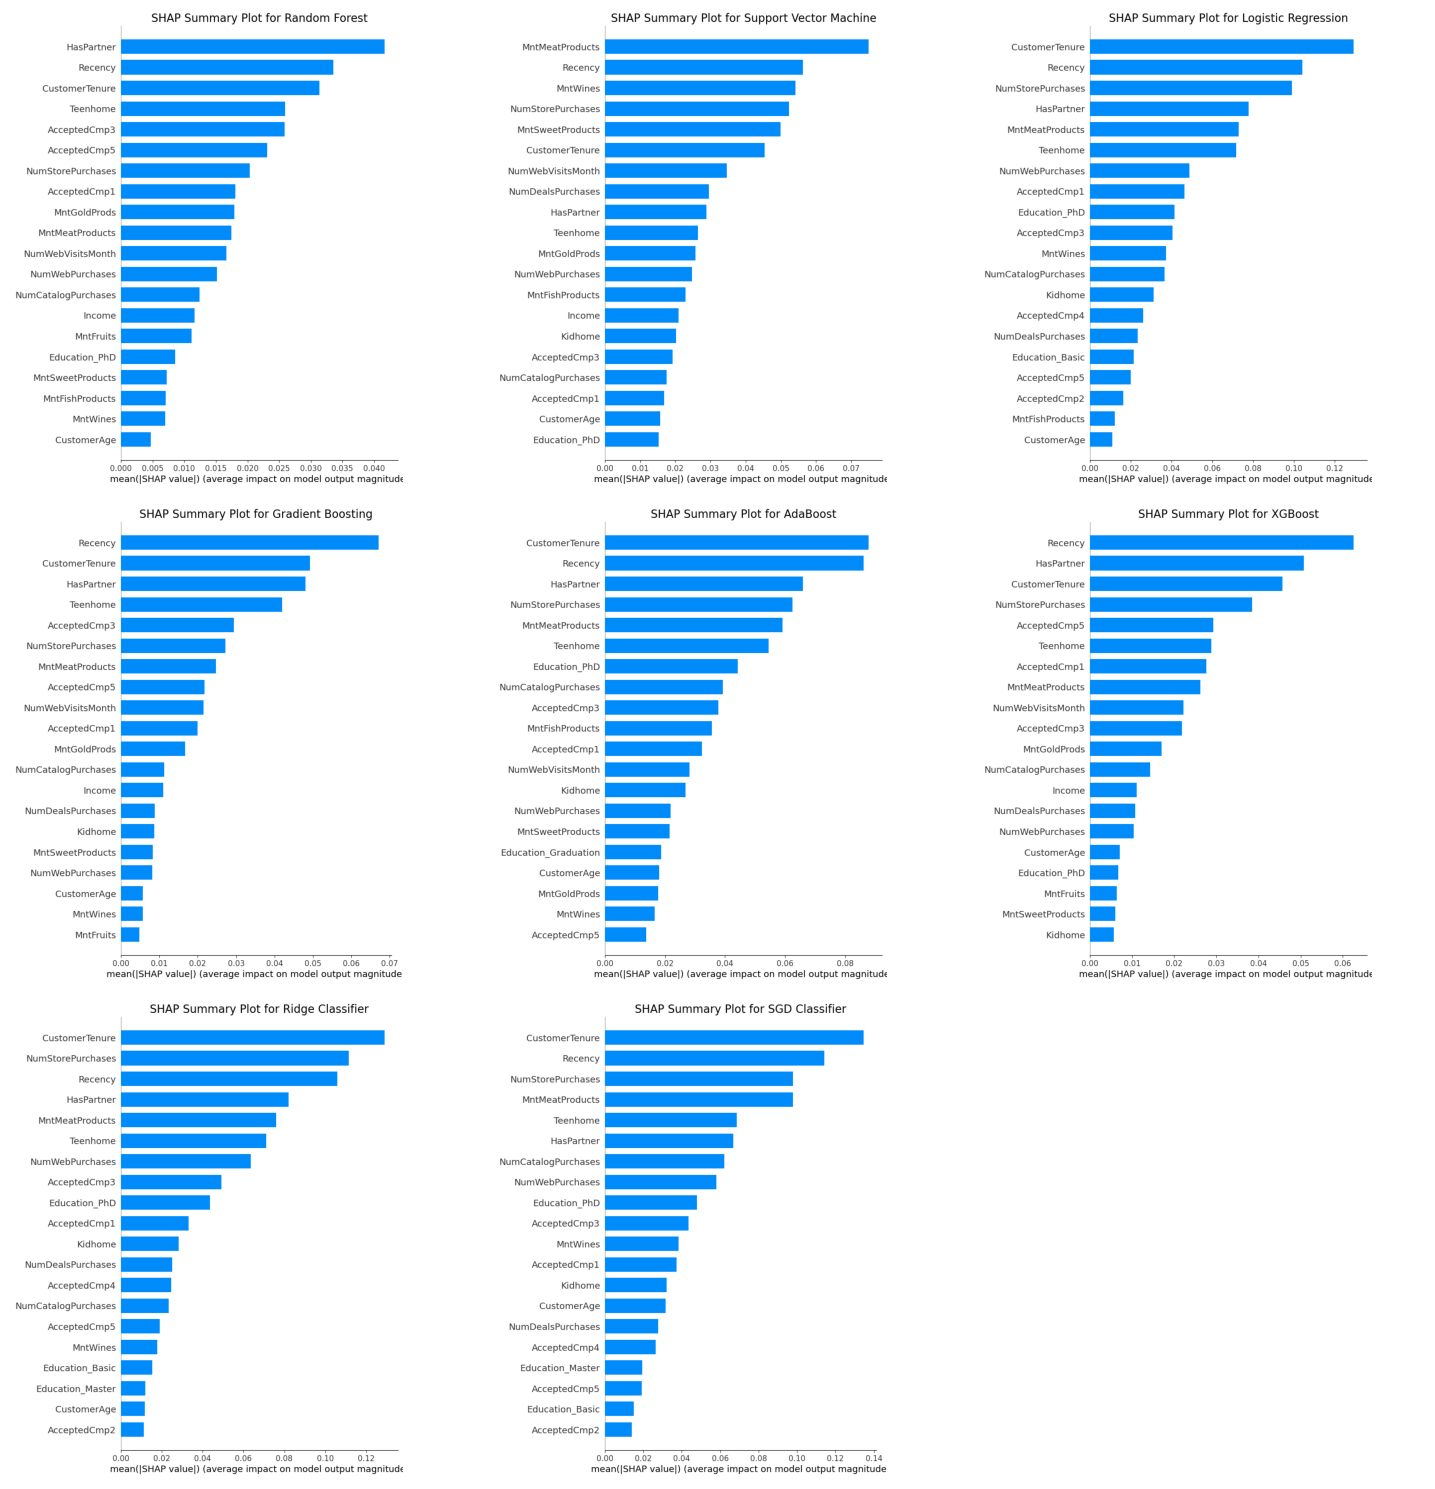

In [22]:
output_dir = "../reports/figures/shap_plots"

feature_names = data["feature_names"]

# Generate and save SHAP summary plots
for clf_name, shap_values in shap_values_dict.items():
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False, plot_type="bar")
    plt.title(f"SHAP Summary Plot for {clf_name}", fontsize=16)
    plt.savefig(f"{output_dir}/{clf_name}_shap_summary.png", bbox_inches='tight')
    plt.close()

# Plot SHAP values for each classifier
num_classifiers = len(shap_values_dict)
num_cols = 3
num_rows = (num_classifiers + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

for ax, (clf_name, _) in zip(axes, shap_values_dict.items()):
    img = plt.imread(f"{output_dir}/{clf_name}_shap_summary.png")
    ax.imshow(img)
    ax.axis('off')
    #ax.set_title(f"SHAP Summary Plot for {clf_name}")

# Hide any unused subplots
for i in range(num_classifiers, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()